In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is :  <class 'numpy.ndarray'>  with dimensions:  (540, 960, 3)


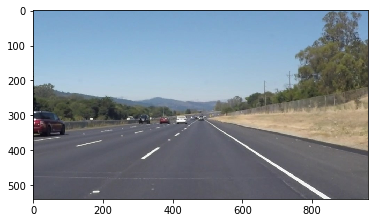

In [2]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

print('This image is : ',type(image), ' with dimensions: ', image.shape)
plt.imshow(image)

In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

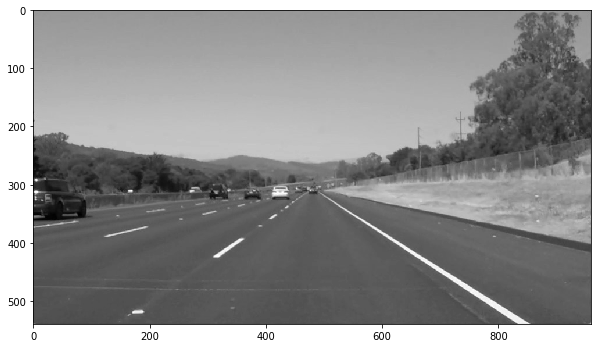

In [4]:
gray_img = grayscale(image)
plt.figure(figsize=(10,8))
plt.imshow(gray_img,cmap='gray')

In [5]:
def gaussion_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size,kernel_size), 0)

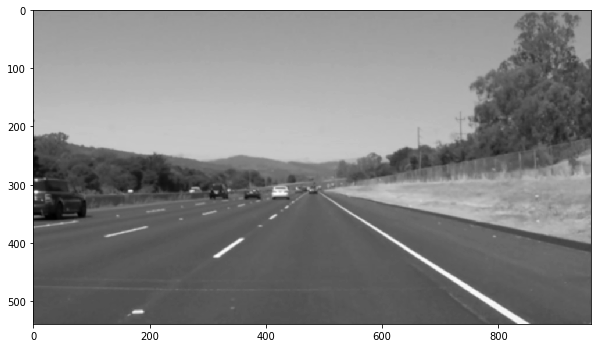

In [6]:
gaussion_img = gaussion_blur(gray_img,5)
plt.figure(figsize=(10,8))
plt.imshow(gaussion_img,cmap='gray')

In [7]:
def canny(img, low_th, high_th):
    return cv2.Canny(img, low_th, high_th)

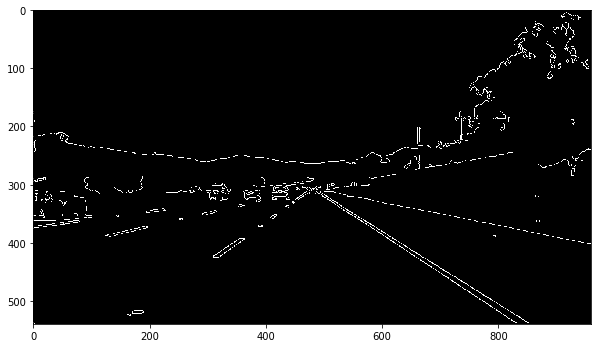

In [8]:
canny_img = canny(gaussion_img,50,150)
plt.figure(figsize=(10,8))
plt.imshow(canny_img,cmap='gray')

In [9]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    
    if len(img.shape)>2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    #在多边形区域填充颜色
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #img图像中，只有mask遮罩区域内的图像能被输出
    masked_img = cv2.bitwise_and(img,mask)
    return masked_img

只显示兴趣区域内的直线

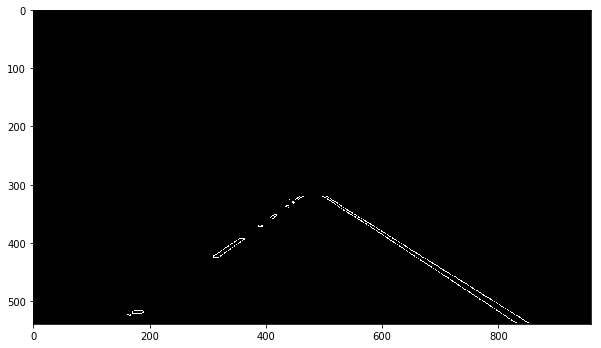

In [10]:
vertices_ =np.array([[(450,320),(540,320),(900,539),(90,539)]])
masked_img = region_of_interest(canny_img,vertices_)
plt.figure(figsize=(10,8))
plt.imshow(masked_img,cmap='gray')

#霍夫变换检测到的直线画在图上

In [11]:
def draw_lines_channel(img,lines,color=255,thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img,(x1,y1),(x2,y2),color,thickness)

In [12]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1]),dtype=np.uint8)
    draw_lines_channel(line_img,lines)
    return line_img

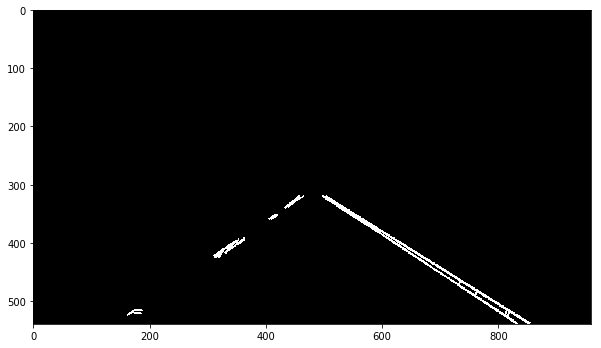

In [13]:
hough_img = hough_lines(masked_img,1,np.pi/180,threshold=1,min_line_len=10,max_line_gap=10)
plt.figure(figsize=(10,8))
plt.imshow(hough_img,cmap='gray')

In [14]:
#收集图中画出的直线坐标，返回两条直线点集
#参数：左上和右下的坐标
def get_lines_points(img,vertices):
    points_left, points_right = [], []
    x1,y1,x2,y2 = vertices[0],vertices[1],vertices[2],vertices[3]
    for i in range(y1,y2):
        for j in range(x1,x2):
            if img[i,j] >0:
                if j<(x1+x2)/2:
                    points_left.append((j,i))
                else:
                        points_right.append((j,i))
    left = np.array([points_left])
    right = np.array([points_right])
    return left,right

In [15]:
def draw_connection_line(img,line,color=[255,0,0],thickness=10):
    rows,cols = img.shape[:2] 
    vx,vy,x,y = line[0],line[1],line[2],line[3]
    lefty = int((-x*vy/vx) + y)  
    righty = int(((cols-x)*vy/vx)+y)  
    result = cv2.line(img,(cols-1,righty),(0,lefty),color,thickness)
    return result

In [16]:
#参数说明：左上和右下的坐标
def connect_hough_lines(img,vertices,color=[255,0,0],thickness=10):
    points_left,points_right = get_lines_points(img,vertices)
    [vx1,vy1,x1,y1] = cv2.fitLine(points_left, cv2.DIST_HUBER,0,0.01,0.01)  
    [vx2,vy2,x2,y2] = cv2.fitLine(points_right, cv2.DIST_HUBER,0,0.01,0.01)  
    zero_img = np.zeros((img.shape[0], img.shape[1],3),dtype=np.uint8)
    left_img = draw_connection_line(zero_img,[vx1,vy1,x1,y1],color=color,thickness=thickness)
    result_img = draw_connection_line(left_img,[vx2,vy2,x2,y2],color=color,thickness=thickness)
    return result_img

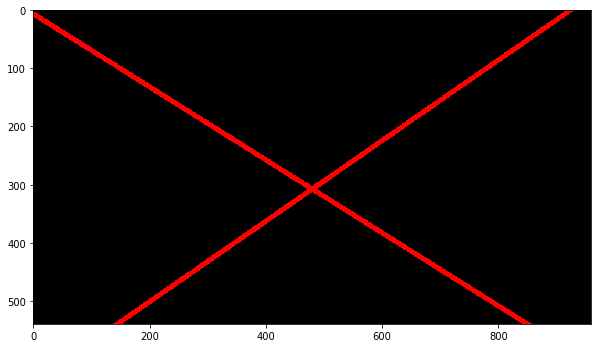

In [17]:
connect_img = connect_hough_lines(hough_img,[90,320,900,539],thickness=7)
plt.figure(figsize=(10,6))
plt.imshow(connect_img)

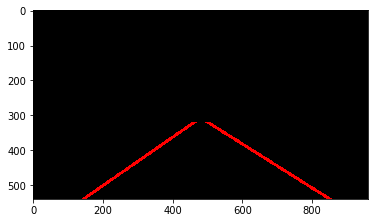

In [18]:
connect_img_re = region_of_interest(connect_img,vertices_)
plt.imshow(connect_img_re)

In [19]:
def weighted_img(img,initial_img,alpha=0.8,beta=1.,gama=0):
    return cv2.addWeighted(initial_img,alpha,img,beta,gama)

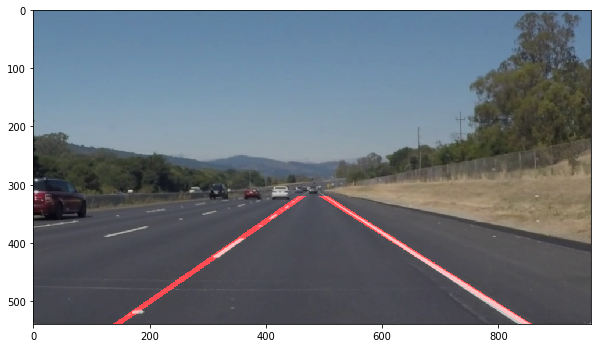

In [20]:
out_img = weighted_img(connect_img_re,image)
plt.figure(figsize=(10,6))
plt.imshow(out_img)